# Digital twin tutorial

## How to build a machine learning-assisted simulation models

A small tutorial for explaining the use of machine learning in structural dynamics: vibration prediction using a hybrid (ODE solver + recurrent neural network) method 

by *Merten Stender*, m.stender@tuhh.de

Hamburg University of Technology, Dynamics Group (www.tuhh.de/dyn)


### 1. import external libraries

In [15]:
import numpy as np
import aux_funs as aux  # some small subroutines for generating the data
from matplotlib import pyplot as plt
import pickle
from scipy.integrate import odeint  # for ODE time integration
import time

### 2. define simulation model

we will use a single-mass damped oscillator to model the dynamics observed in the experiment:

$\ddot{x} + 2 \delta \dot{x} + \omega_{n}^{2} x = 0$

Suppose that a first (and very rough) system identification obtained the following model parameters: $\delta = 0.25$, $\omega_n = 3$. We will implement the dynamical system as first-order ordinary differential equation (ODE) as given below:

$\dot{x}_1 = x_2$ 

$\dot{x}_2 = -2 \delta x_2 - \omega_{n}^{2} x_1$

In [16]:
def simulation_model(x, t):
    
    delta = 0.25
    omega = 3
    
    dxdt = [x[1], 
           - 2 * delta * x[1] - omega**2 * x[0]]
    
    return dxdt

### 3. Load measurement data

we load some locally stored measurement data. Particularly, the data is *small*, such that we have only $n_{\mathrm{samples}}=100$ measurements. Each measurement consists of $n_{\mathrm{timesteps}}=200$ samples for the $n_{\mathrm{dof}}=2$ degrees of freedom (displacement $x(t)$ and the velocity $\dot{x}(t)$). 

The measurement data will be stored in the tensor $\texttt{XM}$, wich has the dimensions $[n_{\mathrm{samples}} \times n_{\mathrm{timesteps}} \times n_{\mathrm{dof}}]$. $\texttt{T}$ is the time vector

In [17]:
file = open('historic_data.p', 'rb')
data = pickle.load(file); file.close()    # close the file

XM = data[0]    # list of numpy arrays [n_samples x n_timesteps x n_dof]
T = data[1]     # corresponding time vectors
n_timesteps = len(T)

display the first sample of the measurement data

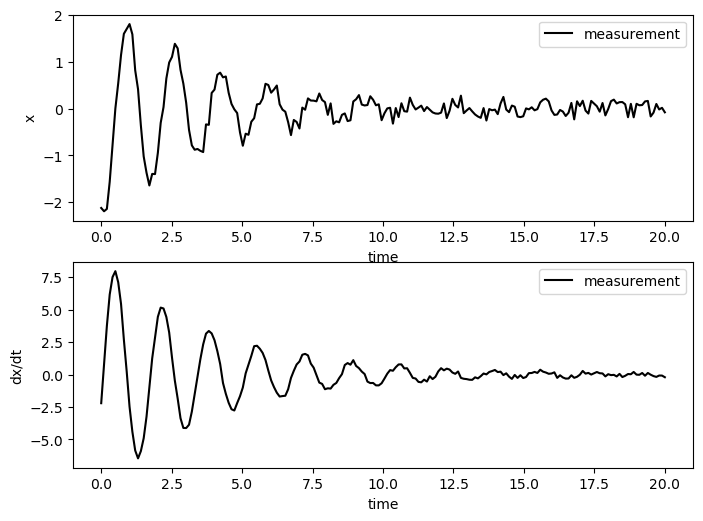

In [18]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplot(2,1,1)
plt.plot(T, XM[0, :, 0], color='black')
plt.xlabel("time"); plt.ylabel("x"); plt.legend(['measurement'])

plt.subplot(2,1,2)
plt.plot(T, XM[0, :, 1], color='black')
plt.xlabel("time"); plt.ylabel("dx/dt"); plt.legend(['measurement'])
plt.show()

### 4. compute simulation predictions for the measurement data

Starting from the initial values provided in the measurement data set, we compute the time signals that our physics-based model, i.e. the single-degree-of-freedom oscillator, would produce.

In [19]:
XS = []  # store all the simulation data in this list

for idx in range(XM.shape[0]):

    print('time integration ' + str(idx) + '/' + str(XM.shape[0]))
    # run a time integration of the physics-based model from the initial conditions provided in the measurement data
    xS = odeint(simulation_model, XM[idx, 0, :], T)
    XS.append(xS)

# convert to 3D numpy array to be consistent with XM
XS = np.array(XS)

time integration 0/100
time integration 1/100
time integration 2/100
time integration 3/100
time integration 4/100
time integration 5/100
time integration 6/100
time integration 7/100
time integration 8/100
time integration 9/100
time integration 10/100
time integration 11/100
time integration 12/100
time integration 13/100
time integration 14/100
time integration 15/100
time integration 16/100
time integration 17/100
time integration 18/100
time integration 19/100
time integration 20/100
time integration 21/100
time integration 22/100
time integration 23/100
time integration 24/100
time integration 25/100
time integration 26/100
time integration 27/100
time integration 28/100
time integration 29/100
time integration 30/100
time integration 31/100
time integration 32/100
time integration 33/100
time integration 34/100
time integration 35/100
time integration 36/100
time integration 37/100
time integration 38/100
time integration 39/100
time integration 40/100
time integration 41/100
ti

now compare our model prediction to the measurement data. We can compare the signals themselves, and also compute the Euclidean distance per time step

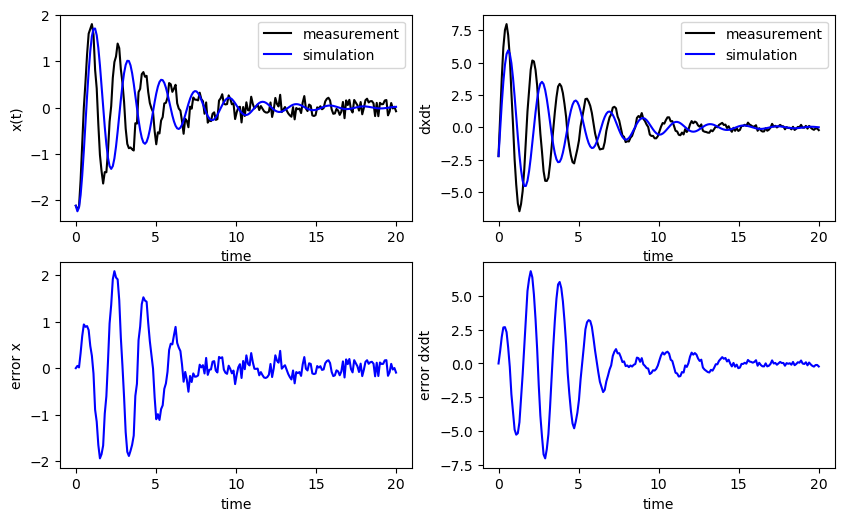

In [20]:
plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(2, 2, 1)
plt.xlabel("time")
plt.ylabel("x(t)")
plt.plot(T, XM[0, :, 0], color='black')
plt.plot(T, XS[0, :, 0], color='blue')
plt.legend(['measurement', 'simulation'])

plt.subplot(2, 2, 2)
plt.xlabel("time")
plt.ylabel("dxdt")
plt.plot(T, XM[0, :, 1], color='black')
plt.plot(T, XS[0, :, 1], color='blue')
plt.legend(['measurement', 'simulation'])

plt.subplot(2, 2, 3)
plt.xlabel("time")
plt.ylabel("error x")
plt.plot(T, XM[0, :, 0] - XS[0, :, 0], color='blue')

plt.subplot(2, 2, 4)
plt.xlabel("time")
plt.ylabel("error dxdt")
plt.plot(T, XM[0, :, 1] - XS[0, :, 1], color='blue')
plt.show()

Compute the mean absolute error (MAE) between simulations and measurement

$\mathrm{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| x_{S,i} - x_{M, i} \right|$

In [21]:
print('MAE of the simulation is ' + str(np.round(aux.get_mae(XS, XM), 2)))

MAE of the simulation is 0.8


### 6. Design a hybrid digital twin to arrive at better predictions

following the presentation, we build a recurrent neural network model that can compensate for the simulation errors to come up with a better prediction given a set of initial values 

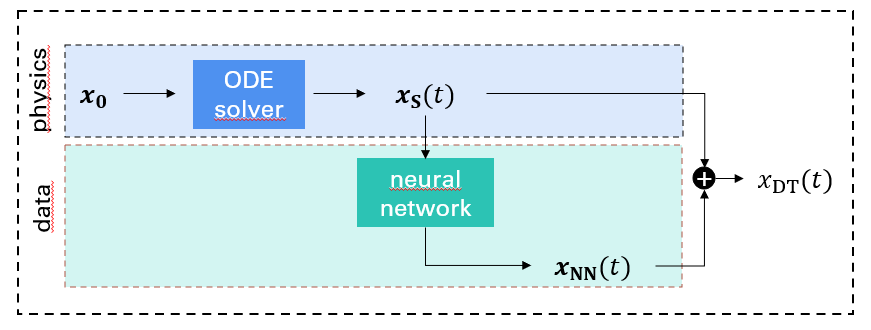

In [22]:
# a) define inputs and outputs
X_in = XS          # input: the simulation time series
X_out = XM - XS    # output: difference between measurement and simulation

# b) split into train-test set (80-20)
split_ratio = 0.8
X_in_train, X_in_test, X_out_train, X_out_test, XM_train, XM_test = aux.split_data(X_in, X_out, XM, split_ratio)

# c) check shapes
print('shape of X_in_train is: ' + str(X_in_train.shape) + '; shape of X_out_train is: ' + str(X_out_train.shape))
print('shape of X_in_test is: ' + str(X_in_test.shape) + '; shape of X_out_test is: ' + str(X_out_test.shape))

shape of X_in_train is: (80, 200, 2); shape of X_out_train is: (80, 200, 2)
shape of X_in_test is: (20, 200, 2); shape of X_out_test is: (20, 200, 2)


#### build recurrent neural network
now construct a recurrent neural network using the Keras API and LSTM and Dense layers. This model is quite simple ('vanilla-type model'), but for this first prototype it is complex enough, having ~42.000 parameters to be optimized during training

In [23]:
#from keras.utils import to_categorical
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

n_dof = 2
# n_outputs = n_timesteps

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_dof),return_sequences=True))  # we use 150 LSTM units here
model.add(Dropout(0.2))
model.add(Dense(n_dof, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])  # MAE: Mean absolute error
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200, 100)          41200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 200, 2)            202       
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________


now train the model on the training set. Observe also the performance on the test set to spot overfitting

In [24]:
epochs, batch_size = 100, 64

start = time.time()  # measure training time
history = model.fit(X_in_train, X_out_train, 
                    shuffle=True, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_in_test, X_out_test), 
                    verbose=1)
end = time.time()
print('--> training took ' + str(np.round(end-start, 2)) + ' seconds')

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 3s 38ms/step - loss: 2.5432 - mae: 0.8019 - val_loss: 2.6083 - val_mae: 0.8195
Epoch 2/100
80/80 [==============================] - 1s 10ms/step - loss: 2.4027 - mae: 0.7799 - val_loss: 2.4614 - val_mae: 0.7965
Epoch 3/100
80/80 [==============================] - 1s 11ms/step - loss: 2.2748 - mae: 0.7593 - val_loss: 2.3218 - val_mae: 0.7747
Epoch 4/100
80/80 [==============================] - 1s 11ms/step - loss: 2.1418 - mae: 0.7387 - val_loss: 2.1825 - val_mae: 0.7533
Epoch 5/100
80/80 [==============================] - 1s 11ms/step - loss: 2.0122 - mae: 0.7183 - val_loss: 2.0411 - val_mae: 0.7317
Epoch 6/100
80/80 [==============================] - 1s 11ms/step - loss: 1.8850 - mae: 0.6987 - val_loss: 1.8965 - val_mae: 0.7099
Epoch 7/100
80/80 [==============================] - 1s 12ms/step - loss: 1.7497 - mae: 0.6784 - val_loss: 1.7483 - val_mae: 0.6882
Epoch 8/100
80/80 [=============

80/80 [==============================] - 9s 114ms/step - loss: 0.0847 - mae: 0.2053 - val_loss: 0.0625 - val_mae: 0.1765
Epoch 63/100
80/80 [==============================] - 8s 96ms/step - loss: 0.0839 - mae: 0.2040 - val_loss: 0.0605 - val_mae: 0.1752
Epoch 64/100
80/80 [==============================] - 5s 67ms/step - loss: 0.0824 - mae: 0.2017 - val_loss: 0.0595 - val_mae: 0.1737
Epoch 65/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0809 - mae: 0.1998 - val_loss: 0.0563 - val_mae: 0.1697
Epoch 66/100
80/80 [==============================] - 5s 68ms/step - loss: 0.0791 - mae: 0.1981 - val_loss: 0.0550 - val_mae: 0.1678
Epoch 67/100
80/80 [==============================] - 4s 52ms/step - loss: 0.0769 - mae: 0.1961 - val_loss: 0.0530 - val_mae: 0.1653
Epoch 68/100
80/80 [==============================] - 1s 18ms/step - loss: 0.0746 - mae: 0.1935 - val_loss: 0.0519 - val_mae: 0.1637
Epoch 69/100
80/80 [==============================] - 1s 10ms/step - loss: 0.0735

Evaluate the training process and the final accuracy. Overfitting may occur, which can be observed through increasing training scores and decreasing test scores (diverging loss curves). 

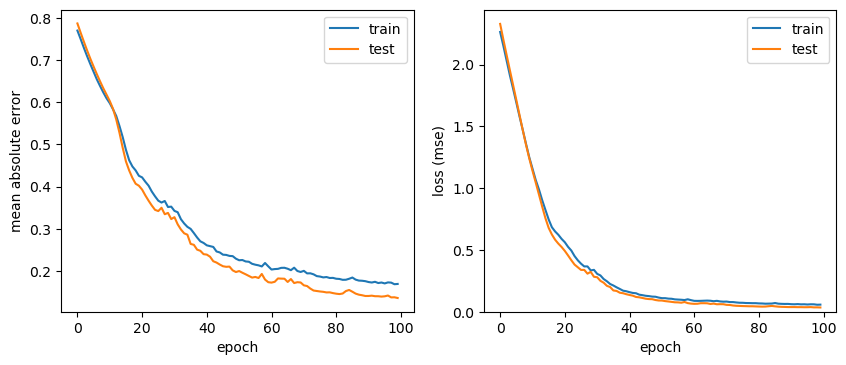

MAE of the neural network is 0.14


In [11]:
# evaluate the model to obtain a final test score
_, mae = model.evaluate(X_in_test, X_out_test, batch_size=batch_size, verbose=0)

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
# plt.ylim([0, 1])
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.ylim(ymin=0)
plt.show()

print('MAE of the neural network is ' + str(np.round(mae,2)))

### 8. compile the hybrid digital twin

Now we have all the ingredients ready for compiling the digital twin:
- **physics-based simulation model** (still not being optimal)
- **data-driven machine learning model** (compensating for the model errors)

The behavior prediction for a given initial condition $\mathbf{x}_{0}$ will be a three-step process:
1. run a time integration using the simulation model to obtain $\mathbf{x}_{S}$
2. provide $\mathbf{x}_{S}$ as input to the trained ML model to obtain the correction values $\mathbf{x}_{NN}$
3. obtain the final prediction by adding the previous results: $\mathbf{x}_{DT} = \mathbf{x}_{S} + \mathbf{x}_{NN}$


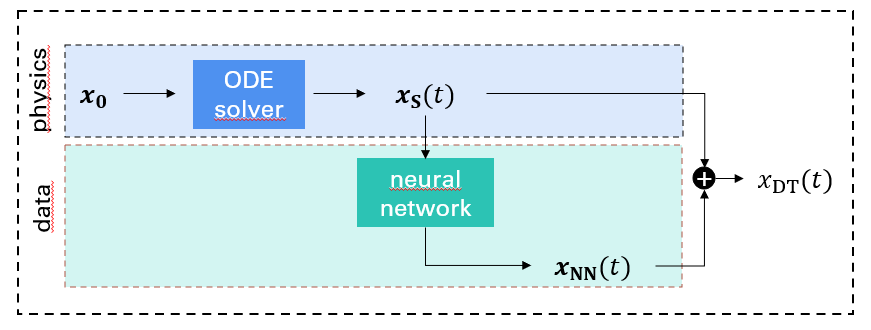

In [12]:
def digital_twin(x0, T):

    # 1. get simulation result
    xS = odeint(simulation_model, x0, T)

    # 2. feed simulation into the deep learning model to get correction factors
    xNN = model.predict(np.dstack(np.transpose(xS)))
    xNN = xNN[0, :, :]

    # 3. add simulation and RNN prediction
    xDT = xS + xNN

    return xDT, xS

### 9. make a prediction

1. make a prediction for a data sample from the test set. The ML model has not seen these data before, so it's a good check if our model and the digital twin generalize well.
2. make a prediction for an initial value that lies outside the value range spanned by the training set. Let's see how we perform there

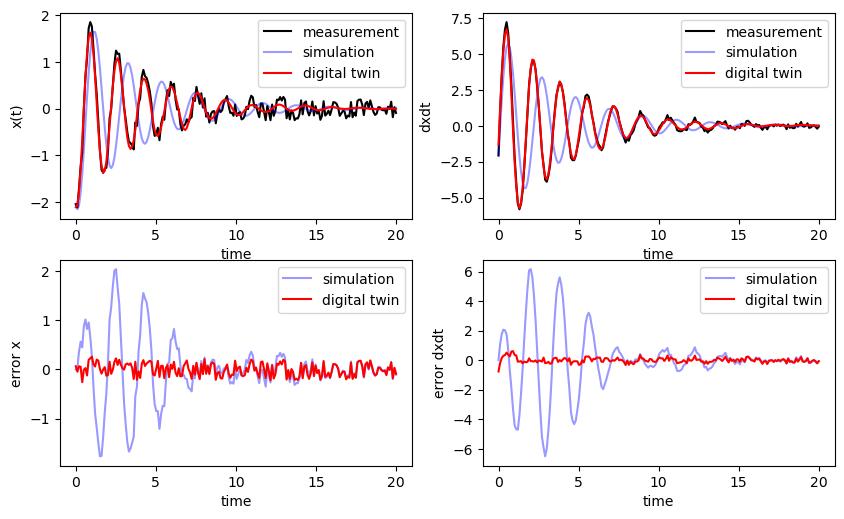

MAE of the simulation: 0.76
MAE of the digital twin: 0.12


In [13]:
xM_sample = XM_test[0, :, :]  # 1. test data sample
xDT_sample, xS_sample = digital_twin(xM_sample[0,:], T)

plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(2, 2, 1)
plt.xlabel("time")
plt.ylabel("x(t)")
plt.plot(T, xM_sample[:, 0], color='black')
plt.plot(T, xS_sample[:, 0], color='blue', alpha=0.4)
plt.plot(T, xDT_sample[:, 0], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 2)
plt.xlabel("time")
plt.ylabel("dxdt")
plt.plot(T, xM_sample[:, 1], color='black')
plt.plot(T, xS_sample[:, 1], color='blue', alpha=0.4)
plt.plot(T, xDT_sample[:, 1], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 3)
plt.xlabel("time")
plt.ylabel("error x")
plt.plot(T, xM_sample[:, 0] - xS_sample[:, 0], color='blue', alpha=0.4)
plt.plot(T, xM_sample[:, 0] - xDT_sample[:, 0], color='red')
plt.legend(['simulation', 'digital twin'])

plt.subplot(2, 2, 4)
plt.xlabel("time")
plt.ylabel("error dxdt")
plt.plot(T, xM_sample[:, 1] - xS_sample[:, 1], color='blue', alpha=0.4)
plt.plot(T, xM_sample[:, 1] - xDT_sample[:, 1], color='red')
plt.legend(['simulation', 'digital twin'])
plt.show()

print('MAE of the simulation: '+ str(np.round(aux.get_mae(xS_sample, xM_sample), 2)))
print('MAE of the digital twin: '+ str(np.round(aux.get_mae(xDT_sample, xM_sample), 2)))

### Extrapolation 

now make a prediction for $\mathbf{x}_{0} = [-4, -5]^{\top}$ which is a configuration that lies outside of the training data range. By chance, we have some experimental data for these values, so we can compare the twin to reality

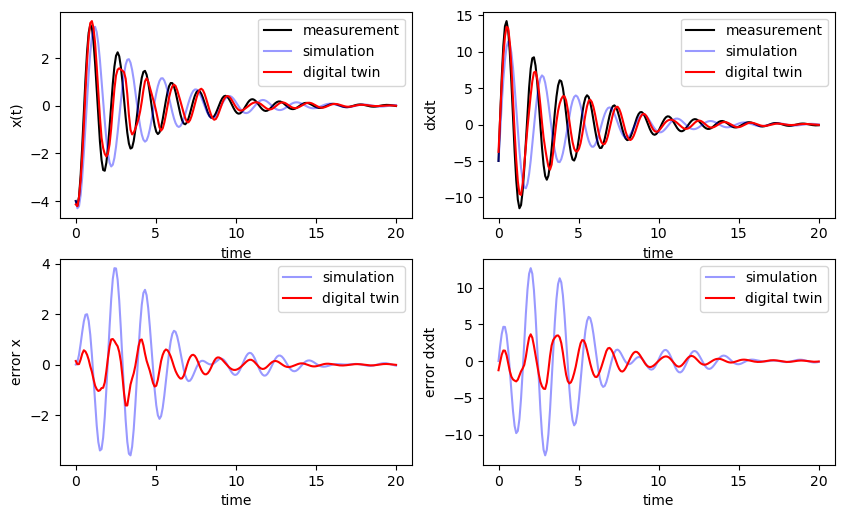

MAE of the simulation: 1.47
MAE of the digital twin: 0.56


In [14]:
x0_new = [-4, -5]
xDT_new, xS_new = digital_twin(x0_new, T)     # make a prediction
xM_new = aux.get_measurement_data(x0_new, T)  # load the corresponding data


plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(2, 2, 1)
plt.xlabel("time")
plt.ylabel("x(t)")
plt.plot(T, xM_new[:, 0], color='black')
plt.plot(T, xS_new[:, 0], color='blue', alpha=0.4)
plt.plot(T, xDT_new[:, 0], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 2)
plt.xlabel("time")
plt.ylabel("dxdt")
plt.plot(T, xM_new[:, 1], color='black')
plt.plot(T, xS_new[:, 1], color='blue', alpha=0.4)
plt.plot(T, xDT_new[:, 1], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 3)
plt.xlabel("time")
plt.ylabel("error x")
plt.plot(T, xM_new[:, 0] - xS_new[:, 0], color='blue', alpha=0.4)
plt.plot(T, xM_new[:, 0] - xDT_new[:, 0], color='red')
plt.legend(['simulation', 'digital twin'])

plt.subplot(2, 2, 4)
plt.xlabel("time")
plt.ylabel("error dxdt")
plt.plot(T, xM_new[:, 1] - xS_new[:, 1], color='blue', alpha=0.4)
plt.plot(T, xM_new[:, 1] - xDT_new[:, 1], color='red')
plt.legend(['simulation', 'digital twin'])
plt.show()

print('MAE of the simulation: '+ str(np.round(aux.get_mae(xS_new, xM_new), 2)))
print('MAE of the digital twin: '+ str(np.round(aux.get_mae(xDT_new, xM_new), 2)))